In [67]:
%matplotlib inline
import matplotlib
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates
from scipy.stats import gaussian_kde
import operator
import pylab
import pandas as pd
from html import HTML
from itertools import groupby
from operator import itemgetter
import itertools
from collections import Counter

In [68]:
admit_file = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/all_icu_tracking/icuadmit.csv"
collection_file = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/all_icu_tracking/collection.csv"

In [69]:
def convert_to_python_dates (our_date, delim):
    year,month,day = map(int, our_date.split(delim))
    if year < 1000:
        year+=2000 # corrects for the year been just two digits
    return datetime.date(year, month, day)


In [70]:
def consecutive(a, b):
    return abs((a - b).days) == 1

In [71]:
def set_up_dict(admit_file):
    '''
    Returns:
    sample_dict = key =(person,admit_date,room) -> {}
    exit_dict = key = (person, room) -> exit dates
    '''
    with open(admit_file) as f:
        headerline = f.readline()
        temp_dict={} # key=(patient_id, room) -> list of dates patient in room
        s_dict={} #key =(person,admit_date,room) -> {} 
        e_dict={} #exit dictionary: key = (patient,room) -> exit dates
        for l in f:
            ll = l.strip().split(",")
            pid,tmp,room,tmp2 = ll[0:4]
            report_date = convert_to_python_dates(tmp2,"-")
            temp_dict.setdefault((pid,room), set()).add(convert_to_python_dates(tmp2,"-"))
        for key in temp_dict:
            sdates = sorted(temp_dict[key])
            if len(sdates) == 1: #person only in ICU for a day
                s_dict[key[0],sdates[0],key[1]]={}
                e_dict.setdefault((key[0],key[1]), set()).add(sdates[0])
            else: #person in ICU for more than one day
                admit_date = min(sdates)
                exit_date = max(sdates)
                s_dict[key[0],admit_date,key[1]]={}
                e_dict.setdefault((key[0],key[1]), set()).add(exit_date)
                for i in xrange(1, len(sdates)):
                    if sdates[i] - sdates[i-1] > datetime.timedelta(1):
                        s_dict[key[0],sdates[i],key[1]]={}
                        e_dict.setdefault((key[0],key[1]), set()).add(sdates[i-1])
                          
        return s_dict, e_dict

In [72]:
sample_dict_empty, all_exit_dict = set_up_dict(admit_file)


In [73]:
def make_full_exit_dict(s_dict_empty,exit_dict):
    '''
    Takes in the dictionaries of admit dates and exit dates
    returns dictionary: key = (person, admit_date, room) -> exit date
    '''
    f_exit_dict = {}
    for key in s_dict_empty:
        if (key[0],key[2]) in exit_dict:
            pid = key[0]
            ad = key[1]
            room = key[2]
            if len(exit_dict[key[0],key[2]]) == 1:
                f_exit_dict[key[0],key[1],key[2]] = exit_dict[key[0],key[2]] #One stay in the icu
            else:
                admit_dates = sorted([item[1] for item in s_dict_empty if item[0]==pid and item[2] == room])
                discharge_dates = sorted(exit_dict[(key[0],key[2])])
                for i in xrange(len(discharge_dates)-1):
                    if admit_dates[i] <= discharge_dates[i]: #and admit_dates[i] > discharge_dates[i]:
                        f_exit_dict[pid,ad,room] = discharge_dates[i]
                    else:
                        print "other"
                    
    return f_exit_dict

In [74]:
full_exit_dict = make_full_exit_dict(sample_dict_empty,all_exit_dict)

In [75]:
def get_exit_date(pid,admit_date,icu):
    '''
    returns the exit date for an individual visit
    '''
    query = full_exit_dict[(pid,admit_date,icu)]
    lq = list(query)
    return lq

In [76]:
def get_sampling_dates(col_file):
    '''
    Adds in the sample collection information to give the following dictionary:
    q_dict[(person,room)] = [(sample_date1,stool),(sample_date2,swab)...(sample_daten,stool)]

    '''
    q_dict={}
    with open(col_file) as f:
        headerline = f.readline()
        for l in f:
            ll = l.strip().split(",")
            pid,icu,collection_date,tmp2,sample_type = ll[0:6]
            if tmp2 == "NULL":
                sampling_date = convert_to_python_dates(collection_date,"-") #Use collection date instead  
                b = sampling_date,sample_type
            else:
                sampling_date = convert_to_python_dates(tmp2,"-") #Use actual sampling date
                b = sampling_date,sample_type
            q_dict.setdefault((pid,icu), set()).add(b)
    return q_dict

In [77]:
sampling_dates = get_sampling_dates(collection_file)

In [78]:
def date_cutoff(sde,cutoffs):
    '''
    cutoffs is a dictionary keyed on icu with values of the start dates
    ex. 
    Returns dirctionary to only include individuals that were admitted to an ICU on or after a certain date
    '''
    new_dict = {}
    for key in sde:
            if key[2] in cutoffs:
                start = cutoffs[key[2]]
                if key[1] >= start:
                    new_dict[key[0],key[1],key[2]] = {}
    return new_dict     

In [79]:
cutoff_dates = {'SICU': datetime.date(2015,9,14), 'MICU': datetime.date(2015,12,1), 'NSIC': datetime.date(2015,11,17)}

In [80]:
new_empty_dict = date_cutoff(sample_dict_empty,cutoff_dates)

In [81]:
def make_full_dict(s_dates,samp_dict_empty):
    '''
    Concatenate the two dictionaries and make a full dictionary with all of the info
    Inputs:
    sampling_dates  = 
    sample_dict_empty = (person,admit_date,room) -> {}
    Returns:
    final_dic = (person,admit_date,room) -> [(sample_date1,stool),(sample_date2,swab)...(sample_daten,stool)]
    '''
    final_dict = {} 
    no_visit_samples = Counter()
    pre_first_samples = Counter()
    for key in s_dates:
        visits = [entry for entry in samp_dict_empty if key[0] == entry[0] and key[1] == entry [2]]
        visits.sort(lambda x,y: cmp(x[1], y[1]))
        nvis = len(visits)
        if nvis == 0: 
            no_visit_samples[key[0]] += 1
            continue
        for date in s_dates[key]: # check the dates at least 1 day before because of epic record lag
            date_found = False
            mod_date = date[0]+datetime.timedelta(1)
            if mod_date >= visits[-1][1]:
                final_dict.setdefault(visits[-1], set()).add(date)
                date_found = True
            for i in xrange(nvis-1): # going to add in a check for end of loop
                if mod_date >= visits[i][1] and mod_date < visits[i+1][1]:
                    final_dict.setdefault(visits[i],set()).add(date)
                    date_found = True
            if not date_found:        
            #    print mod_date
            #    print visits
            #    print "this sample doesn't exist between admits:", date, key
            #    print "these are the visits corresponding", visits
                pre_first_samples[key[0]] += 1
    #Get non sampled
    non_sampled = []
    for key in samp_dict_empty:
        if key not in final_dict:
            if (key[0],key[2]) in s_dates:
                non_sampled.append(key[0])
                final_dict[key] = s_dates[key[0],key[2]]
            else: final_dict[key]="0" #meaning non sampled
   
    #print "patients with samples and no admits: "
    #print no_visit_samples
    
    no_samples = open("Samples_w_no_visits.txt",'w')
    for sample in no_visit_samples:
        no_samples.write(sample)
        no_samples.write('\n')
    no_samples.close()
    
    samples_before_fn = open("Samples_before_first_admit.txt",'w')
    for sample in pre_first_samples:
        samples_before_fn.write(sample)
        samples_before_fn.write('\n')
    samples_before_fn.close()
    return final_dict
    #print "patients with samples before first admit: "
    #print pre_first_samples
    #print "patients with no samples" #people that we just miss the first time -> for unknown reason, but they get added in
    #print non_sampled
    #return final_dict

In [82]:
sample_dict_full = make_full_dict(sampling_dates,new_empty_dict)

In [83]:
sample_sets = Counter()
for p_visit in sample_dict_full:
    if sample_dict_full[p_visit] == '0':
        sample_sets[(p_visit[-1], 'None')] += 1
    else:
        coll_types = set()
        for coll in sample_dict_full[p_visit]:
            coll_types.add(coll[1])
        if 'Swabs' in coll_types and 'Stools' in coll_types:
            sample_sets[(p_visit[-1], 'Both')] += 1
        else:
            for ctype in coll_types:
                sample_sets[(p_visit[-1], ctype)] += 1
keys = sample_sets.keys()
keys.sort()
for key in keys:
    value = sample_sets[key]
    print key, value

('MICU', 'Both') 24
('MICU', 'None') 46
('MICU', 'Stools') 16
('MICU', 'Swabs') 32
('NSIC', 'Both') 11
('NSIC', 'NULL') 2
('NSIC', 'None') 128
('NSIC', 'Stools') 18
('NSIC', 'Swabs') 53
('SICU', 'Both') 33
('SICU', 'Deleted') 4
('SICU', 'NULL') 4
('SICU', 'None') 83
('SICU', 'Stools') 57
('SICU', 'Swabs') 91


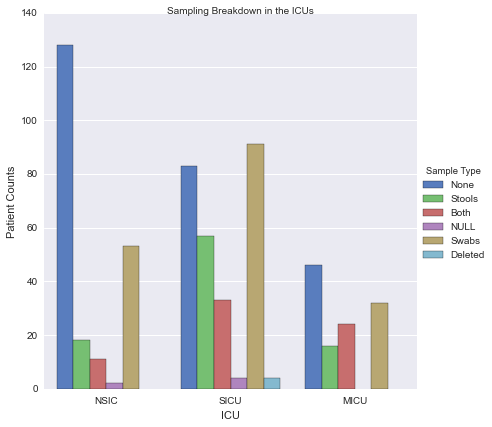

In [84]:
import seaborn as sbn

df = pd.DataFrame([
    [col1[0],col1[1],col3] for col1, col3 in sample_sets.items() 
])
df.columns = ["ICU","Sample Type", "Counts"]

a = df.to_html(index=False) 
table1 = open("table1.html",'w')
table1.write(a)

# Draw a nested barplot to show survival for class and sex
g = sbn.factorplot(x="ICU", y="Counts", hue="Sample Type", data=df,
                   size=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("Patient Counts")


g.fig.suptitle('Sampling Breakdown in the ICUs') # can also get the figure from plt.gcf()
g.savefig("sampling_breakdown.png")


In [85]:
def get_patients_sampled_within_x_days(s_dict_full,x,icu,ex_dict):
    end_date = datetime.date.today()
    current_dict = { key:value for key,value in s_dict_full.items() if key[2] == icu}
    start_date = cutoff_dates[icu]
    daterange = (end_date-start_date).days # days between first and last date
    date_bins = map(lambda x: datetime.timedelta(x)+start_date, range(x,daterange,x))
    total_patients   = []
    sampled_patients = []
    for bin_end_date in date_bins:
        bin_start_date = bin_end_date-datetime.timedelta(x)
        bsd = bin_start_date
        bed = bin_end_date
        pidsInDate = set()
        for visit in current_dict:
            if visit not in ex_dict:
                print "not in"
            else:
                pid = visit[0]
                exit_date_set =  full_exit_dict[visit]
                admit_date = visit[1]
                if type(exit_date_set) == set:
                    exit_date = list(exit_date_set)[0]
                else:
                    exit_date = exit_date_set
                if admit_date >= bsd and admit_date <= bed:
                    pidsInDate.add(pid)
                elif exit_date >= bsd and exit_date <= bed:
                    pidsInDate.add(pid)
                elif admit_date <= bsd and exit_date >= bed:
                    pidsInDate.add(pid)
        pidsCollected = set()
        for pid in pidsInDate:
            if (pid,icu) in sampling_dates:
                pidCoDates = sampling_dates[(pid,icu)]
                for codate in pidCoDates:
                    date_of_sample = codate[0]
                    if date_of_sample >= bsd and date_of_sample <= bed:
                        pidsCollected.add(pid)
                        break
        total_patients.append(len(pidsInDate))
        sampled_patients.append(len(pidsCollected))
    
    return total_patients, sampled_patients, date_bins        


### def get_mean_length_between_samples(collectionDates):

In [86]:
SICU_rates = get_patients_sampled_within_x_days(sample_dict_full,5, 'SICU', full_exit_dict)
MICU_rates = get_patients_sampled_within_x_days(sample_dict_full,5, 'MICU', full_exit_dict)
NSIC_rates = get_patients_sampled_within_x_days(sample_dict_full,5, 'NSIC', full_exit_dict)

In [87]:
SICU_ratio =  np.array(SICU_rates[1],dtype='float')/np.array(SICU_rates[0],dtype='float')
MICU_ratio =  np.array(MICU_rates[1],dtype='float')/np.array(MICU_rates[0],dtype='float')
NSIC_ratio =  np.array(NSIC_rates[1],dtype='float')/np.array(NSIC_rates[0],dtype='float')

In [95]:
rats=[]
rats.append(SICU_ratio)
rats.append(MICU_ratio)
rats.append(NSIC_ratio)


labels = ["SICU", "MICU", "NSIC"]
plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 5 day bins')
plt.axis([0,13,0,1])

for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
days=[]
for date in SICU_rates[2]:
    days.append("%s" % str(date))
    days.append(str(date))
    
    
dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')

plt.savefig("five_day_bins.png", bbox_inches='tight')
plt.close() # Close a figure window

In [96]:
SICU_rates = get_patients_sampled_within_x_days(sample_dict_full,2, 'SICU', full_exit_dict)
MICU_rates = get_patients_sampled_within_x_days(sample_dict_full,2, 'MICU', full_exit_dict)
NSIC_rates = get_patients_sampled_within_x_days(sample_dict_full,2, 'NSIC', full_exit_dict)
SICU_ratio =  np.array(SICU_rates[1],dtype='float')/np.array(SICU_rates[0],dtype='float')
MICU_ratio =  np.array(MICU_rates[1],dtype='float')/np.array(MICU_rates[0],dtype='float')
NSIC_ratio =  np.array(NSIC_rates[1],dtype='float')/np.array(NSIC_rates[0],dtype='float')
rats=[]
rats.append(SICU_ratio)
rats.append(MICU_ratio)
rats.append(NSIC_ratio)


labels = ["SICU", "MICU", "NSIC"]
plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 2 day bins')
plt.axis([0,13,0,1])

for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
days=[]
for date in SICU_rates[2]:
    days.append("%s" % str(date))
    days.append(str(date))
    
    
dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')

plt.savefig("two_day_bins.png", bbox_inches='tight')
plt.close() # Close a figure window

In [97]:
SICU_rates = get_patients_sampled_within_x_days(sample_dict_full,3, 'SICU', full_exit_dict)
MICU_rates = get_patients_sampled_within_x_days(sample_dict_full,3, 'MICU', full_exit_dict)
NSIC_rates = get_patients_sampled_within_x_days(sample_dict_full,3, 'NSIC', full_exit_dict)
SICU_ratio =  np.array(SICU_rates[1],dtype='float')/np.array(SICU_rates[0],dtype='float')
MICU_ratio =  np.array(MICU_rates[1],dtype='float')/np.array(MICU_rates[0],dtype='float')
NSIC_ratio =  np.array(NSIC_rates[1],dtype='float')/np.array(NSIC_rates[0],dtype='float')
rats=[]
rats.append(SICU_ratio)
rats.append(MICU_ratio)
rats.append(NSIC_ratio)


labels = ["SICU", "MICU", "NSIC"]
plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 3 day bins')
plt.axis([0,13,0,1])

for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
days=[]
for date in SICU_rates[2]:
    days.append("%s" % str(date))
    days.append(str(date))
    
    
dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')

plt.savefig("three_day_bins.png", bbox_inches='tight')
plt.close() # Close a figure window

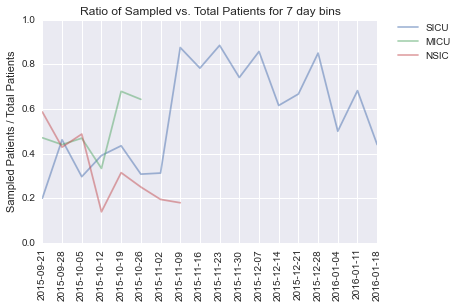

In [104]:
SICU_rates = get_patients_sampled_within_x_days(sample_dict_full,7, 'SICU', full_exit_dict)
MICU_rates = get_patients_sampled_within_x_days(sample_dict_full,7, 'MICU', full_exit_dict)
NSIC_rates = get_patients_sampled_within_x_days(sample_dict_full,7, 'NSIC', full_exit_dict)
SICU_ratio =  np.array(SICU_rates[1],dtype='float')/np.array(SICU_rates[0],dtype='float')
MICU_ratio =  np.array(MICU_rates[1],dtype='float')/np.array(MICU_rates[0],dtype='float')
NSIC_ratio =  np.array(NSIC_rates[1],dtype='float')/np.array(NSIC_rates[0],dtype='float')
rats=[]
rats.append(SICU_ratio)
rats.append(MICU_ratio)
rats.append(NSIC_ratio)

labels = ["SICU", "MICU", "NSIC"]
plt.ylabel('Sampled Patients / Total Patients')
plt.title('Ratio of Sampled vs. Total Patients for 7 day bins')
plt.axis([0,13,0,1])

for i in range(len(rats)):
    if len(rats[i]) > 0:
        plt.plot(rats[i],label=labels[i],alpha=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
days=[]
for date in SICU_rates[2]:
    days.append("%s" % str(date))
    days.append(str(date))
    
    
dayrange=len(days)/2
plt.xticks(range(dayrange), days[0::2], size='medium',rotation='vertical')
plt.show()
plt.savefig("seven_day_bins.png", bbox_inches='tight')
plt.close() # Close a figure window